In [39]:
!pip install numpy
!pip install matplotlib
!pip install scipy

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

In [41]:

# Parameters
num_subcarriers = 64
cyclic_prefix_length = num_subcarriers // 4
num_pilot_carriers = 8
pilot_value = 3 + 3j
mu = 4  # bits per symbol (16QAM)
SNRdb = 25  # signal to noise-ratio in dB at the receiver

In [42]:
# Generate pilot and data carrier indices
all_carriers = np.arange(num_subcarriers)
pilot_carriers = all_carriers[::num_subcarriers // num_pilot_carriers]
pilot_carriers = np.hstack([pilot_carriers, np.array([all_carriers[-1]])])
num_pilot_carriers += 1
data_carriers = np.delete(all_carriers, pilot_carriers)

all_carriers:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
pilot_carriers: [ 0  8 16 24 32 40 48 56 63]
data_carriers:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62]


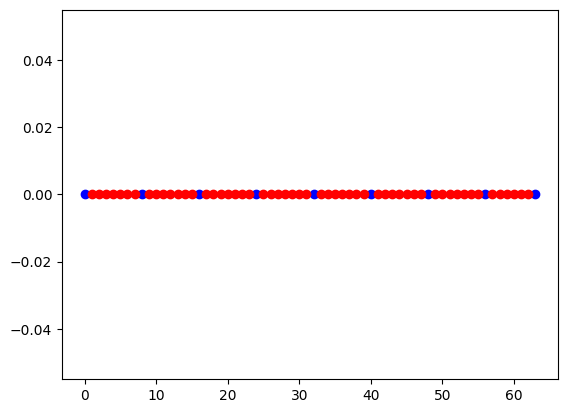

In [43]:
print("all_carriers:   %s" % all_carriers)
print("pilot_carriers: %s" % pilot_carriers)
print("data_carriers:  %s" % data_carriers)

plt.plot(pilot_carriers, np.zeros_like(pilot_carriers), 'bo', label='pilot')
plt.plot(data_carriers, np.zeros_like(data_carriers), 'ro', label='data')


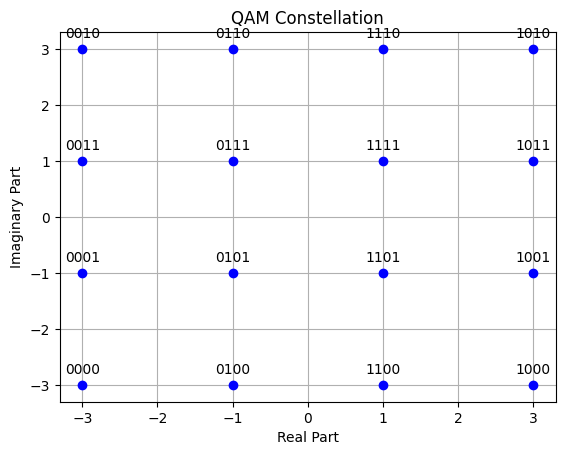

In [44]:
payload_bits_per_OFDM = len(data_carriers) * mu  # number of payload bits per OFDM symbol

mapping_table = {
    (0, 0, 0, 0): -3 - 3j,
    (0, 0, 0, 1): -3 - 1j,
    (0, 0, 1, 0): -3 + 3j,
    (0, 0, 1, 1): -3 + 1j,
    (0, 1, 0, 0): -1 - 3j,
    (0, 1, 0, 1): -1 - 1j,
    (0, 1, 1, 0): -1 + 3j,
    (0, 1, 1, 1): -1 + 1j,
    (1, 0, 0, 0): 3 - 3j,
    (1, 0, 0, 1): 3 - 1j,
    (1, 0, 1, 0): 3 + 3j,
    (1, 0, 1, 1): 3 + 1j,
    (1, 1, 0, 0): 1 - 3j,
    (1, 1, 0, 1): 1 - 1j,
    (1, 1, 1, 0): 1 + 3j,
    (1, 1, 1, 1): 1 + 1j
}

for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag + 0.2, "".join(str(x) for x in B), ha='center')

plt.grid(True)
plt.title('QAM Constellation')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.show()


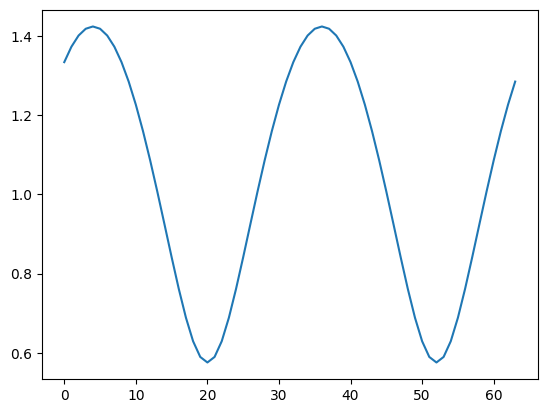

In [45]:
demapping_table = {v: k for k, v in mapping_table.items()}
channel_response = np.array([1, 0, 0.3 + 0.3j])  # Impulse response of the wireless channel
H_exact = np.fft.fft(channel_response, num_subcarriers)
plt.plot(all_carriers, abs(H_exact))



In [46]:
bits = np.random.binomial(n=1, p=0.5, size=(payload_bits_per_OFDM,))
print("Bits count:", len(bits))
print("First 20 bits:", bits[:20])
print("Mean of bits (should be around 0.5):", np.mean(bits))


Bits count: 220
First 20 bits: [1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0]
Mean of bits (should be around 0.5): 0.4636363636363636


In [47]:
def SP(bits):
    """
    Serial-to-parallel converter.
    
    Groups the bits for the OFDM frame into groups of mu bits 
    (i.e., one group for each subcarrier).
    """
    return bits.reshape((len(data_carriers), mu))

bits_SP = SP(bits)
print("First 5 bit groups:")
print(bits_SP[:5, :])


First 5 bit groups:
[[1 0 0 0]
 [1 1 0 0]
 [1 1 0 0]
 [1 1 0 1]
 [1 0 1 0]]


In [48]:
def Mapping(bits):
    """
    Mapper function.
    
    Converts the groups of bits into complex-valued constellation symbols 
    according to the mapping_table.
    
    Parameters:
        bits (array): Array of grouped bits.
    
    Returns:
        array: Array of complex-valued constellation symbols.
    """
    return np.array([mapping_table[tuple(b)] for b in bits])

QAM = Mapping(bits_SP)
print("First 5 QAM symbols and bits:")
print(bits_SP[:5, :])
print(QAM[:5])


First 5 QAM symbols and bits:
[[1 0 0 0]
 [1 1 0 0]
 [1 1 0 0]
 [1 1 0 1]
 [1 0 1 0]]
[3.-3.j 1.-3.j 1.-3.j 1.-1.j 3.+3.j]


In [49]:
def OFDM_symbol(QAM_payload, pilot_carriers, pilot_value, data_carriers, num_subcarriers):
    """
    Create the overall OFDM symbol.
    
    Allocate data and pilot subcarriers in the OFDM symbol.

    Parameters:
        QAM_payload (array): Array of QAM symbols representing the payload.
        pilot_carriers (array): Array of indices of pilot subcarriers.
        pilot_value (complex): Value transmitted by each pilot.
        data_carriers (array): Array of indices of data subcarriers.
        num_subcarriers (int): Total number of subcarriers.

    Returns:
        array: The OFDM symbol.
    """
    symbol = np.zeros(num_subcarriers, dtype=complex)  # The overall K subcarriers
    symbol[pilot_carriers] = pilot_value  # Allocate the pilot subcarriers 
    symbol[data_carriers] = QAM_payload  # Allocate the data subcarriers
    return symbol

OFDM_data = OFDM_symbol(QAM, pilot_carriers, pilot_value, data_carriers, num_subcarriers)
print("Number of OFDM carriers in frequency domain:", len(OFDM_data))


Number of OFDM carriers in frequency domain: 64


In [50]:
def IDFT(OFDM_data):
    """
    Perform Inverse Discrete Fourier Transform (IDFT) on the OFDM data.
    
    Parameters:
        OFDM_data (array): The OFDM data in the frequency domain.
    
    Returns:
        array: The OFDM data in the time domain after IDFT operation.
    """
    return np.fft.ifft(OFDM_data)

OFDM_time = IDFT(OFDM_data)
print("Number of OFDM samples in time-domain before CP:", len(OFDM_time))


Number of OFDM samples in time-domain before CP: 64


In [51]:
def addCP(OFDM_time, cyclic_prefix_length):
    """
    Add a cyclic prefix to the OFDM time domain signal.
    
    This operation concatenates a copy of the last CP samples of the OFDM time domain signal to the beginning.

    Parameters:
        OFDM_time (array): The OFDM signal in the time domain.
        cyclic_prefix_length (int): Length of the cyclic prefix.

    Returns:
        array: The OFDM signal with the cyclic prefix added.
    """
    cp = OFDM_time[-cyclic_prefix_length:]  # Take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning

OFDM_withCP = addCP(OFDM_time, cyclic_prefix_length)
print("Number of OFDM samples in time domain with CP:", len(OFDM_withCP))


Number of OFDM samples in time domain with CP: 80


RX Signal power: 0.2158. Noise power: 0.0007


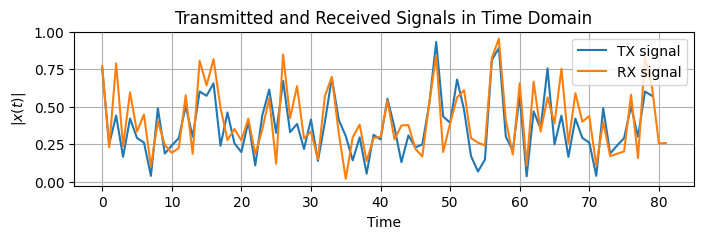

In [52]:
def channel(signal, channel_response, SNRdb):
    """
    Simulate the wireless channel by convolving the signal with the channel response
    and adding noise according to the given SNR value.
    
    Parameters:
        signal (array): The transmitted signal.
        channel_response (array): The impulse response of the wireless channel.
        SNRdb (float): Signal-to-noise ratio in dB.

    Returns:
        array: The received signal after passing through the channel and noise.
    """
    convolved = np.convolve(signal, channel_response)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR

    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))

    print("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))

    return convolved + noise

OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX, channel_response, SNRdb)

plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time')
plt.ylabel('$|x(t)|$')
plt.grid(True)
plt.title('Transmitted and Received Signals in Time Domain')
plt.show()


In [53]:
def removeCP(signal, cyclic_prefix_length, num_subcarriers):
    """
    Remove the cyclic prefix from the received signal.
    
    Parameters:
        signal (array): The received signal with cyclic prefix.
        cyclic_prefix_length (int): Length of the cyclic prefix.
        num_subcarriers (int): Number of subcarriers.

    Returns:
        array: The received signal without cyclic prefix.
    """
    return signal[cyclic_prefix_length:(cyclic_prefix_length+num_subcarriers)]

OFDM_RX_noCP = removeCP(OFDM_RX, cyclic_prefix_length, num_subcarriers)

def DFT(OFDM_RX):
    """
    Perform Discrete Fourier Transform (DFT) on the received signal.
    
    Parameters:
        OFDM_RX (array): The received signal in the time domain.

    Returns:
        array: The received signal in the frequency domain after DFT operation.
    """
    return np.fft.fft(OFDM_RX)

OFDM_demod = DFT(OFDM_RX_noCP)


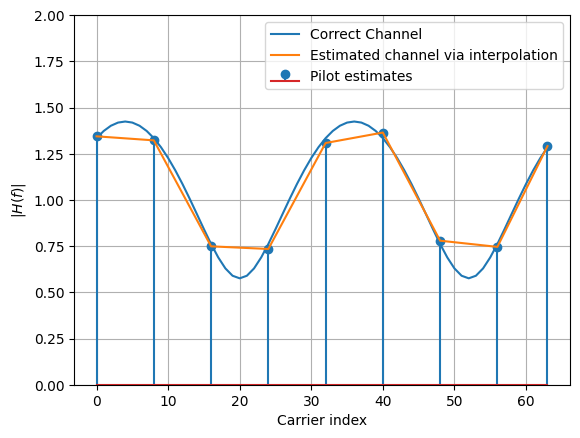

In [54]:
def channelEstimate(OFDM_demod, pilot_carriers, pilot_value, all_carriers, H_exact):
    """
    Estimate the wireless channel using zero-forcing channel estimation followed by interpolation.
    
    Parameters:
        OFDM_demod (array): Demodulated signal received by the OFDM demodulator.
        pilot_carriers (array): Indices of the pilot subcarriers.
        pilot_value (complex): Known value each pilot transmits.
        all_carriers (array): Indices of all subcarriers.
        H_exact (array): Exact channel frequency response.

    Returns:
        array: Estimated channel frequency response.
    """
    pilots = OFDM_demod[pilot_carriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilot_value  # divide by the transmitted pilot values

    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilot_carriers, abs(Hest_at_pilots), kind='linear')(all_carriers)
    Hest_phase = scipy.interpolate.interp1d(pilot_carriers, np.angle(Hest_at_pilots), kind='linear')(all_carriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)

    plt.plot(all_carriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilot_carriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(all_carriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True)
    plt.xlabel('Carrier index')
    plt.ylabel('$|H(f)|$')
    plt.legend(fontsize=10)
    plt.ylim(0, 2)

    return Hest

Hest = channelEstimate(OFDM_demod, pilot_carriers, pilot_value, all_carriers, H_exact)


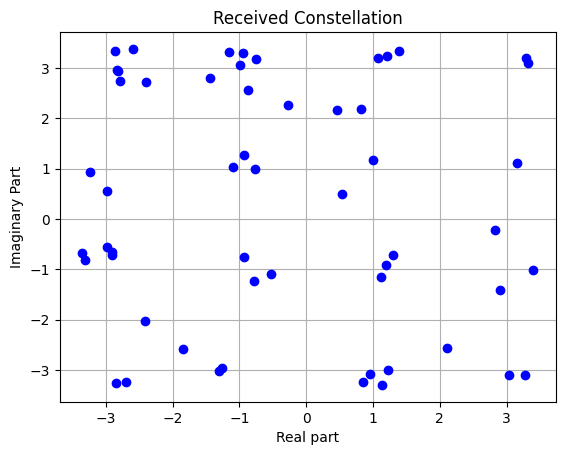

In [55]:
def equalize(OFDM_demod, Hest):
    """
    Equalize the OFDM demodulated signal by dividing by the estimated channel response.
    
    Parameters:
        OFDM_demod (array): Demodulated signal received by the OFDM demodulator.
        Hest (array): Estimated channel frequency response.

    Returns:
        array: Equalized signal.
    """
    return OFDM_demod / Hest

equalized_Hest = equalize(OFDM_demod, Hest)

def get_payload(equalized, data_carriers):
    """
    Extract payload from the equalized OFDM symbol by removing pilot carriers.
    
    Parameters:
        equalized (array): Equalized OFDM symbol.
        data_carriers (array): Indices of the data subcarriers.

    Returns:
        array: Payload symbols.
    """
    return equalized[data_carriers]

QAM_est = get_payload(equalized_Hest, data_carriers)

plt.figure()
plt.plot(QAM_est.real, QAM_est.imag, 'bo')
plt.grid(True)
plt.xlabel('Real part')
plt.ylabel('Imaginary Part')
plt.title('Received Constellation')
plt.savefig("received_constellation.png")


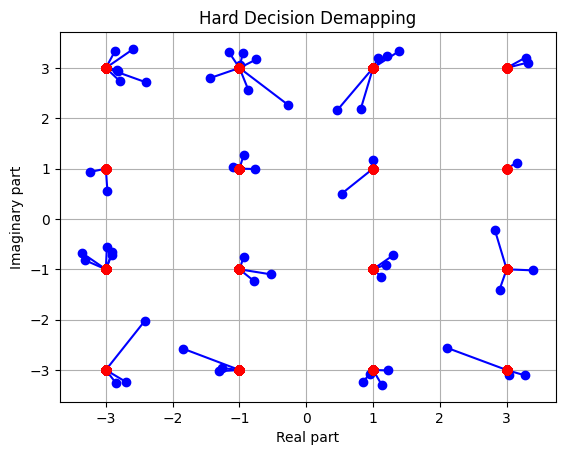

In [56]:
def Demapping(QAM, demapping_table):
    """
    Demap the received QAM symbols back to bit groups based on the closest constellation points.
    
    Parameters:
        QAM (array): Received QAM symbols.
        demapping_table (dict): Mapping table for demapping constellation points to bit groups.

    Returns:
        tuple: Tuple containing demapped bit groups and the corresponding constellation points.
    """
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

PS_est, hardDecision = Demapping(QAM_est, demapping_table)

plt.figure()
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o')
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')
plt.grid(True)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Hard Decision Demapping')
plt.savefig("hard_decision_demapping.png")


In [57]:
def PS(bits):
    """
    Convert bit groups to a serial stream of bits (parallel to serial conversion).
    
    Parameters:
        bits (array): Bit groups.

    Returns:
        array: Serial stream of bits.
    """
    return bits.reshape((-1,))

bits_est = PS(PS_est)

# Calculate the bit error rate
bit_error_rate = np.sum(abs(bits - bits_est)) / len(bits)
print("Obtained Bit error rate:", bit_error_rate)


Obtained Bit error rate: 0.004545454545454545
